In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LassoCV

In [124]:
df = pd.read_excel('proshares_analysis_data.xlsx', sheet_name='hedge_fund_series')
df

,Unnamed: 0,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
0,2011-08-31,-0.032149,-0.025588,-0.025689,-0.027033,-0.006492
1,2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2,2011-10-31,0.026858,0.043593,0.043320,0.050531,0.025244
3,2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
4,2011-12-31,-0.004479,0.001938,0.001796,0.012874,0.001818
...,...,...,...,...,...,...
165,2025-05-31,0.022300,0.019974,0.019702,0.018973,0.019302
166,2025-06-30,0.023300,0.011474,0.010798,0.010599,0.015305
167,2025-07-31,0.009700,0.012114,0.011396,0.009106,0.006813
168,2025-08-31,0.022100,0.013347,0.013024,0.013858,0.015052


In [125]:
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027033,-0.006492
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2011-10-31,0.026858,0.043593,0.043320,0.050531,0.025244
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012874,0.001818


1. For the series in the “hedge fund series” tab, report the following summary statistics:
- Mean
- Volatility
- Sharpe ratio

Annualize these statistics.

In [126]:
summ = pd.DataFrame(index=df.columns, columns=['Mean', 'Volatility', 'Sharpe'])

summ['Mean'] = df.mean() * 12
summ['Volatility'] = df.std() * np.sqrt(12)
summ['Sharpe'] = summ['Mean'] / summ['Volatility']
summ

,Mean,Volatility,Sharpe
HFRIFWI Index,0.051279,0.058796,0.872151
MLEIFCTR Index,0.038535,0.055240,0.697589
MLEIFCTX Index,0.036526,0.055102,0.662880
HDG US Equity,0.026880,0.057388,0.468396
QAI US Equity,0.028811,0.049823,0.578275


2. For the series in the “hedge fund series” tab, calculate the following statistics related to tail-risk.

- Skewness
- Excess Kurtosis (in excess of 3)
- VaR (.05) - the fifth quantile of historic returns
- CVaR (.05) - the mean of the returns at or below the fifth quantile
- Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [127]:
summ['Skewness'] = df.skew()
summ['Excess Kurtosis'] = df.kurtosis()  # .kurtosis() automatically calculates excess (kurt - 3)
summ['VaR'] = df.quantile(.05)
summ['CVaR'] = df[df <= summ['VaR']].mean()

cum_val = (1 + df).cumprod()
peak = cum_val.cummax()
dd = (cum_val - peak) / peak
summ['Max Drawdown'] = dd.min()
summ['Bottom'] = dd.idxmin()

for col in df.columns:
    bottom_date = summ.loc[col, 'Bottom']
    peak_date = cum_val[col].loc[:bottom_date].idxmax()
    post_bottom = cum_val[col].loc[bottom_date:]
    recovery_date = post_bottom[post_bottom >= cum_val[col].loc[peak_date]].index.min()
    summ.loc[col, 'Peak'] = peak_date
    summ.loc[col, 'Recovery'] = recovery_date

summ.round(3)

,Mean,Volatility,Sharpe,Skewness,Excess Kurtosis,VaR,CVaR,Max Drawdown,Bottom,Peak,Recovery
HFRIFWI Index,0.051,0.059,0.872,-0.948,5.657,-0.024,-0.036,-0.115,2020-03-31,2019-12-31,2020-08-31
MLEIFCTR Index,0.039,0.055,0.698,-0.290,1.631,-0.027,-0.035,-0.124,2022-09-30,2021-06-30,2024-02-29
MLEIFCTX Index,0.037,0.055,0.663,-0.273,1.590,-0.027,-0.035,-0.124,2022-09-30,2021-06-30,2024-02-29
HDG US Equity,0.027,0.057,0.468,-0.275,1.776,-0.030,-0.037,-0.141,2022-09-30,2021-06-30,2024-07-31
QAI US Equity,0.029,0.050,0.578,-0.434,1.449,-0.017,-0.031,-0.138,2022-09-30,2021-06-30,2024-02-29


3. For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:
- Market Beta
- Treynor Ratio
- Information ratio

Annualize these three statistics as appropriate.

In [128]:
ml_data = pd.read_excel('proshares_analysis_data.xlsx', sheet_name='merrill_factors')
ml_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
ml_data.set_index('Date', inplace=True)
spy = ml_data[["SPY US Equity"]]
spy = sm.add_constant(spy)
regression_stats = {}
for col in df.columns:
    model = sm.OLS(df[col], spy, missing="drop")
    results = model.fit()

    alpha = results.params.iloc[0]
    beta = results.params.iloc[1]

    regression_stats[col] = {"Market Beta": beta, "Treynor Ratio": (df[col].mean() / beta * 12), "Information Ratio": alpha / results.resid.std() * np.sqrt(12)}
regression_stats_df = pd.DataFrame(regression_stats)
regression_stats_df

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Market Beta,0.346312,0.342487,0.341483,0.350602,0.301413
Treynor Ratio,0.148072,0.112514,0.106963,0.076669,0.095587
Information Ratio,0.055336,-0.436440,-0.510548,-0.862386,-0.597796


4. Discuss the previous statistics, and what they tell us about…
- the differences between SPY and the hedge-fund series?
- which performs better between HDG and QAI.
- whether HDG and the ML series capture the most notable properties of HFRI.

5. Report the correlation matrix for these assets.
- Show the correlations as a heat map.
- Which series have the highest and lowest correlations?

Text(0.5, 1.0, 'Correlation Heatmap')

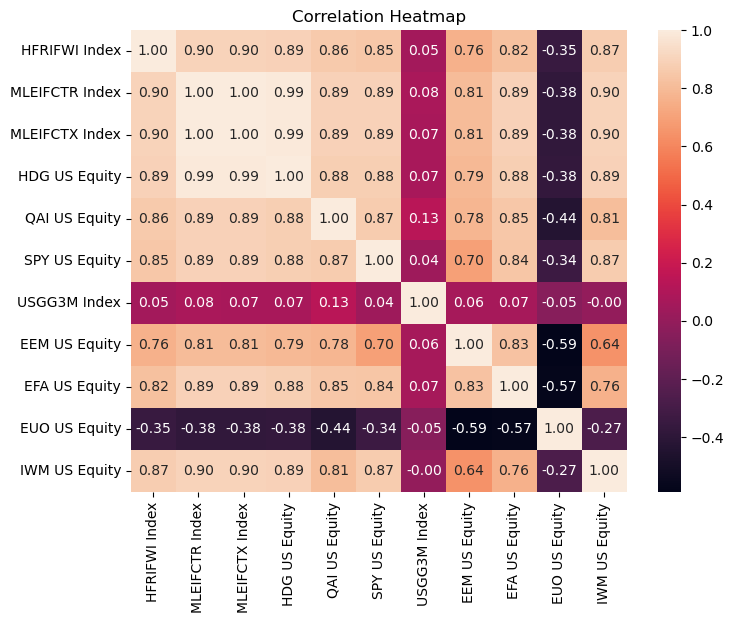

In [129]:
combined = pd.concat([df, ml_data], axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(combined.corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap')

In [130]:
df

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027033,-0.006492
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2011-10-31,0.026858,0.043593,0.043320,0.050531,0.025244
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012874,0.001818
...,...,...,...,...,...
2025-05-31,0.022300,0.019974,0.019702,0.018973,0.019302
2025-06-30,0.023300,0.011474,0.010798,0.010599,0.015305
2025-07-31,0.009700,0.012114,0.011396,0.009106,0.006813
